# Appendix C:Topic Modeling to Classification Modeling

## ADS 509: Final Project Code
## Team 4
### Zachariah Freitas and Brianne Bell
 

Since our data is organized into groups, we will build both a multinomial Logistic Regression classifier and a multinomial Naive Bayes classifier first. We will then report the accuracy of our models against our hold-out test set. 

Once that is complete, we will build NMF, LSA, and LDA topic models, which put our data into topic groups. We will then compare how well those topic models agree with our a priori groups.  

-- updated--
Since our data is organized into groups with overlap of groups ('terms') where each entry has 1-11 groups, we will first determine our own topic groups through topic modeling. 

Once our topic modeling is complete, we will use those results to develop classification models. These will be the multinomial Naive Bayes classifier and multinomial Logistic Regression classifier models. We will then report accuracy of our models against the hold out test set. 

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from collections import Counter 
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from ast import literal_eval
from itertools import islice, cycle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import warnings  
warnings.filterwarnings('ignore')


## Helper Functions

In [2]:
# Add additional helper functions

# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
# tw_punct = punctuation - {"#"} # Do this if there is punctuation you would like to ignore.

# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])

def detokenize(list) : 
    """ Returning back a string from a list of tokens"""
    
    # modify this function to return string from tokens
    return(" ".join([str(e) for e in list]))
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data ETL and EDA

In [3]:
# Get Imported Data
arxiv_data = pd.read_pickle('G:\\My Drive\\ADS-509_Final_Team_Project\\arxiv_data_2023_02_13.pkl')
arxiv_data

,titles,abstracts,terms
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG]
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]"
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG]
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]"
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]"
...,...,...,...
64568,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]"
64569,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV]
64570,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]"
64571,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]"


In [4]:
# Data Review
print(f"There are {len(arxiv_data)} rows in the dataset.\n")

total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicated titles.\n")

dedup_arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()].reset_index(drop=True)
print(f"There are {len(dedup_arxiv_data)} rows in the deduplicated dataset.\n")

# There are some terms with occurrence as low as 1.
occur = sum(dedup_arxiv_data["terms"].value_counts() == 1)
print(f"There are {occur} terms with an occurrence of 1.\n")

# How many unique terms?
unique_terms = dedup_arxiv_data["terms"].astype('str').nunique()
print(f"There are {unique_terms} unique terms.\n")

There are 64573 rows in the dataset.

There are 14237 duplicated titles.

There are 50336 rows in the deduplicated dataset.

There are 2907 terms with an occurrence of 1.

There are 3961 unique terms.



## Normalize and Clean Text


In [5]:
# Clean and Tokenize Data
df = dedup_arxiv_data.copy()

df["summaries"] = df["titles"] + df["abstracts"]

my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop, detokenize]
df["summaries"] = df["summaries"].apply(prepare, pipeline=my_pipeline)

df

,titles,abstracts,terms,summaries
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],reinforcement learning multiple sensors via jo...
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",interventional causal representation learningc...
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],selfsupervised node representation learning vi...
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",outofdistribution representation learning time...
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",trading information latents hierarchical varia...
...,...,...,...,...
50331,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]",plot 94 ambiance xwindowplot collection routin...
50332,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV],automatic face recognition system based local ...
50333,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",convexity analysis snake models based hamilton...
50334,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]",semiautomatic vectorization linear networks ra...


## Topic Modeling

In [6]:
# Helper Functions
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [7]:
# Count the words
count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=0, max_df=0.3)
count_text_vectors = count_text_vectorizer.fit_transform(df['summaries'])
print(count_text_vectors.shape)

(50336, 155123)


In [8]:
# Get TF-IDF
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=0, max_df=0.3)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['summaries'])
print(tfidf_text_vectors.shape)

(50336, 155123)


### Fitting a Non-Negative Matrix Factorization Model - NMF

In [9]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_nmf_text_matrix = nmf_text_model.components_

In [10]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  image (0.75)
  images (0.45)
  segmentation (0.42)
  training (0.30)
  deep (0.27)
  attention (0.26)
  visual (0.26)
  features (0.26)
  semantic (0.26)
  neural (0.25)

Topic 01
  reinforcement (0.91)
  policy (0.84)
  rl (0.76)
  algorithm (0.45)
  algorithms (0.44)
  agents (0.38)
  reward (0.38)
  agent (0.36)
  function (0.33)
  control (0.33)

Topic 02
  graph (3.21)
  graphs (0.97)
  node (0.87)
  neural (0.73)
  gnns (0.73)
  networks (0.65)
  nodes (0.56)
  gnn (0.45)
  representation (0.40)
  structure (0.38)

Topic 03
  3d (3.23)
  point (2.73)
  cloud (1.58)
  depth (1.16)
  clouds (1.10)
  shape (0.75)
  2d (0.68)
  estimation (0.63)
  pose (0.58)
  scene (0.52)

Topic 04
  object (2.83)
  detection (2.64)
  objects (0.87)
  detectors (0.49)
  tracking (0.46)
  detector (0.45)
  dataset (0.38)
  anomaly (0.37)
  bounding (0.35)
  video (0.34)


<AxesSubplot: title={'center': 'Document Count by Category'}, xlabel='Category', ylabel='Document Counts'>

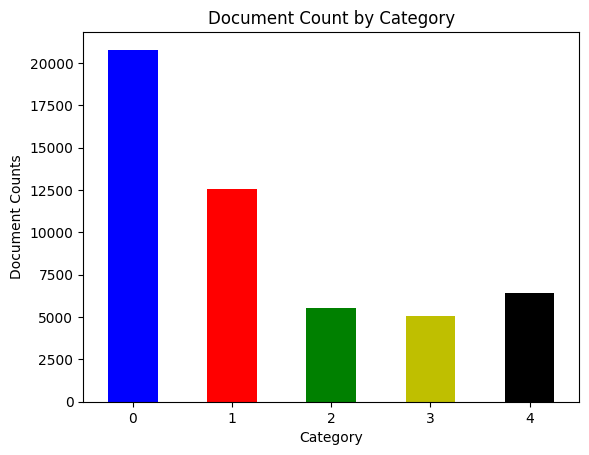

In [11]:
# Evaluate the Categories
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_nmf_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Chart
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
bar_plot = df_new.groupby('nmf_pred_topic_num').size()
ax = bar_plot.plot(kind="bar", stacked=True, rot=0, color=my_colors, title='Document Count by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Document Counts")
display(ax)
print('\n')

### Fitting an LSA Model - LSA

In [12]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, n_iter=14, random_state=42)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_

In [13]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  image (0.34)
  object (0.29)
  detection (0.27)
  graph (0.27)
  3d (0.26)
  neural (0.25)
  deep (0.24)
  images (0.23)
  training (0.22)
  networks (0.22)

Topic 01
  3d (3.69)
  object (3.16)
  detection (2.36)
  point (2.20)
  segmentation (1.69)
  image (1.64)
  depth (1.59)
  images (1.32)
  cloud (1.30)
  objects (1.23)

Topic 02
  graph (13.99)
  graphs (4.07)
  node (3.86)
  gnns (3.19)
  neural (2.77)
  networks (2.61)
  nodes (2.37)
  gnn (1.95)
  classification (1.61)
  representation (1.60)

Topic 03
  point (25.82)
  3d (25.61)
  cloud (15.06)
  graph (11.65)
  clouds (10.29)
  policy (5.88)
  shape (5.68)
  depth (5.23)
  reinforcement (5.11)
  rl (4.78)

Topic 04
  detection (52.93)
  object (52.39)
  graph (15.39)
  objects (12.99)
  detectors (9.87)
  anomaly (9.84)
  tracking (9.30)
  detector (8.76)
  time (7.54)
  series (6.70)


<AxesSubplot: title={'center': 'Document Count by Category'}, xlabel='Category', ylabel='Document Counts'>

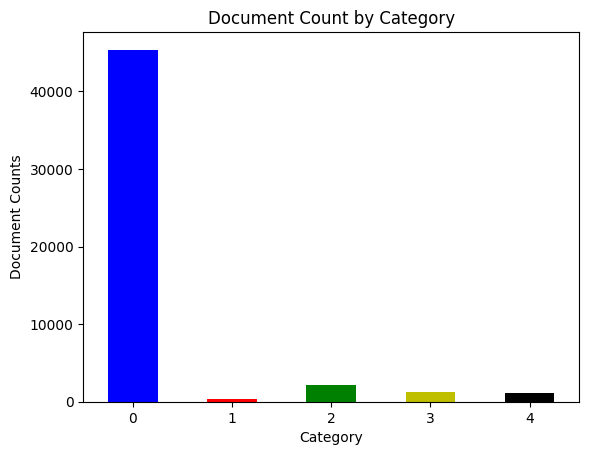

In [14]:
# Evaluate the Categories

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lsa_text_matrix]

# Add to the df
df_new['lsa_pred_topic_num'] = predicted_topics

# Create Chart
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
bar_plot = df_new.groupby('lsa_pred_topic_num').size()
ax = bar_plot.plot(kind="bar", stacked=True, rot=0, color=my_colors, title='Document Count by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Document Counts")
display(ax)
print('\n')

### Fitting an LDA Model - LDA

In [15]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=0)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [16]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  font (0.02)
  glyph (0.01)
  glyphs (0.01)
  nst (0.01)
  bolt (0.01)
  ncdes (0.01)
  vitae (0.01)
  winograd (0.01)
  fingerspelling (0.01)
  spill (0.01)

Topic 01
  image (0.27)
  graph (0.22)
  object (0.22)
  detection (0.22)
  neural (0.22)
  deep (0.21)
  training (0.19)
  images (0.19)
  3d (0.19)
  networks (0.19)

Topic 02
  graphon (0.02)
  frl (0.01)
  de (0.01)
  cmi (0.01)
  whittle (0.01)
  un (0.01)
  graphcl (0.01)
  fmp (0.01)
  chromosomes (0.01)
  fin (0.01)

Topic 03
  spns (0.02)
  vfl (0.01)
  microexpression (0.01)
  mitotic (0.01)
  dpps (0.01)
  htr (0.01)
  capsnets (0.01)
  bangla (0.01)
  microexpressions (0.01)
  mcs (0.01)

Topic 04
  wsi (0.02)
  videoqa (0.02)
  wsis (0.02)
  msrvtt (0.02)
  videolanguage (0.02)
  videotext (0.02)
  garment (0.02)
  msvd (0.01)
  rainfall (0.01)
  textvqa (0.01)


<AxesSubplot: title={'center': 'Document Count by Category'}, xlabel='Category', ylabel='Document Counts'>

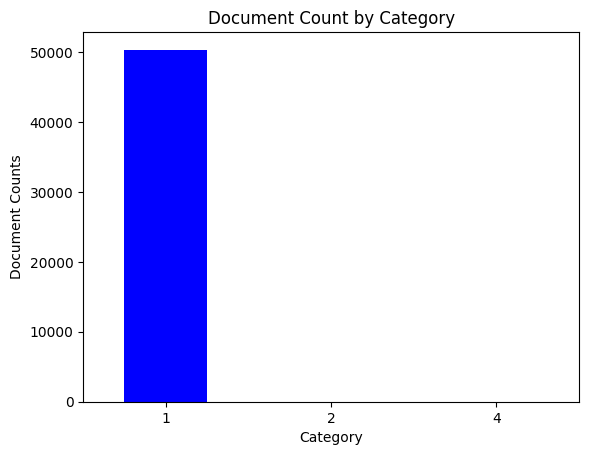

In [17]:
# Evaluate the Categories

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lda_text_matrix]

# Add to the df
df_new['lda_pred_topic_num'] = predicted_topics

# Create Chart
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
bar_plot = df_new.groupby('lda_pred_topic_num').size()
ax = bar_plot.plot(kind="bar", stacked=True, rot=0, color=my_colors, title='Document Count by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Document Counts")
display(ax)
print('\n')

### Topic Model Summary
Reviewing the output of each of our Topic Models we found that the NMF model results made the most sense.  Both In the makeup of their content and in the distribution of documents. Moving forward, we recommend the use of the NMF categories for our predictive classification modeling.

## Word Cloud
Here we wanted to show a word cloud of each of the categories from our preferred Topic Model, NMF.

In [18]:
# plot helper function

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='summaries', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if tokenize is None else tokenize(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


def plot_wc(wordcloud_df, title=None):
    plt.figure(figsize=(12,4))
    wordcloud(wordcloud_df['freq'], title=title, max_words=1000, stopwords=sw)
    plt.tight_layout()###

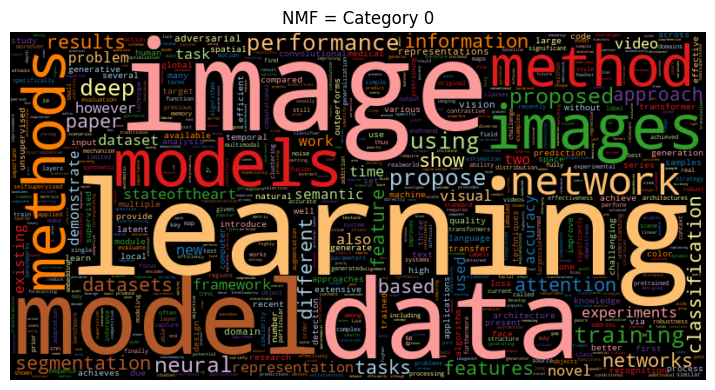

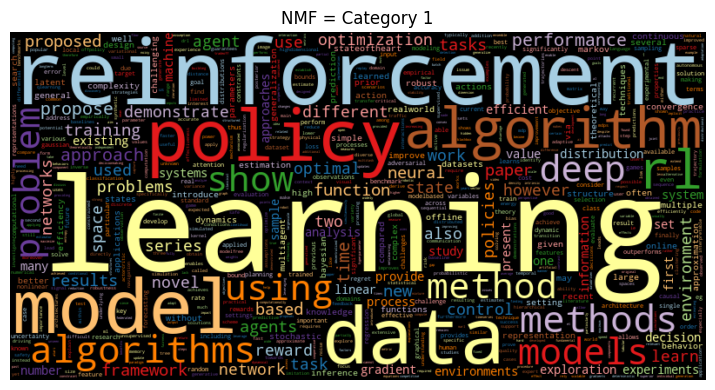

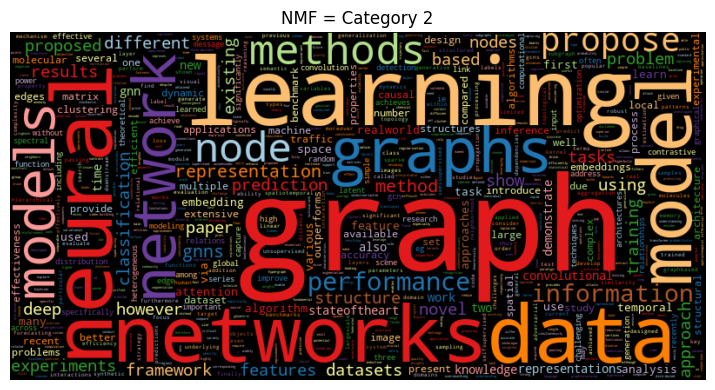

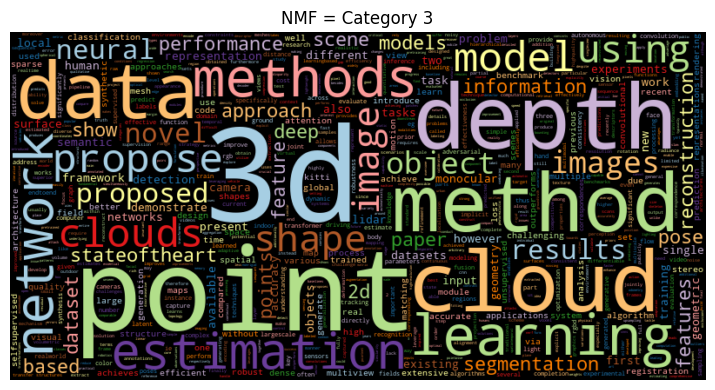

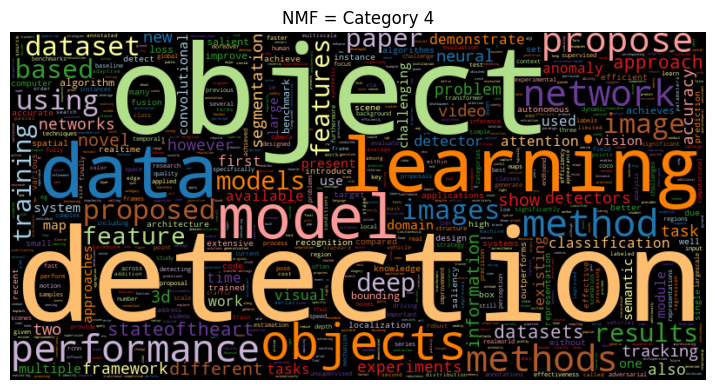

In [19]:
# Plot A Word Cloud for Each NMF Topic Category 
cat_nums = [0,1,2,3,4]
for c in cat_nums:
    wordcloud_df = count_words(df_new.loc[df_new['nmf_pred_topic_num'] ==c])
    plot_wc(wordcloud_df, title = f'NMF = Category {c}')

## Test Train Split

In [20]:
y = pd.get_dummies(df_new['nmf_pred_topic_num'], prefix='cat_', dtype=float)
cat_col_names = list(y.columns)

print(cat_col_names)
y

['cat__0', 'cat__1', 'cat__2', 'cat__3', 'cat__4']


,cat__0,cat__1,cat__2,cat__3,cat__4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
50331,0.0,1.0,0.0,0.0,0.0
50332,1.0,0.0,0.0,0.0,0.0
50333,0.0,0.0,0.0,1.0,0.0
50334,1.0,0.0,0.0,0.0,0.0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['summaries'], 
                                                    pd.get_dummies(df_new['nmf_pred_topic_num'], prefix='cat_', dtype=float), 
                                                    test_size=0.3, 
                                                    random_state=43, 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Classification Modeling

Here we try two approaches for classification modeling.  The first is Logistic Regression, and the second is Multinomial Naïve Bayes. 

### logistic Regression

In [22]:
# Logistic Regression

LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in cat_col_names:
    print('\n**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)

print('Test averaged AUC ROC is {}'.format(accuracy/len(cat_col_names)))


**Processing cat__0 titles...**
AUC ROC score is 0.9430960919157936
[[8287  581]
 [ 301 5932]]


----------------------------------------

**Processing cat__1 titles...**
AUC ROC score is 0.9168420277247727
[[11223   102]
 [  594  3182]]


----------------------------------------

**Processing cat__2 titles...**
AUC ROC score is 0.8910767609582115
[[13412    38]
 [  355  1296]]


----------------------------------------

**Processing cat__3 titles...**
AUC ROC score is 0.9187344567002407
[[13410   144]
 [  235  1312]]


----------------------------------------

**Processing cat__4 titles...**
AUC ROC score is 0.9084195375256585
[[13117    90]
 [  334  1560]]


----------------------------------------
Test averaged AUC ROC is 0.9632607112111782


### Multinomial Naïve Bayes

In [24]:
# Multinomial Naive Bayes

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])
accuracy = 0
for category in cat_col_names:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    conf_mat = confusion_matrix(
        y_test[category], prediction
        )
    print(conf_mat)
    print("\n")
    print("-"*40)


print('Test averaged AUC ROC is {}'.format(accuracy/len(cat_col_names)))

**Processing cat__0 titles...**
AUC ROC is 0.6592175100576682
[[8835   33]
 [4225 2008]]


----------------------------------------
**Processing cat__1 titles...**
AUC ROC is 0.5805084745762712
[[11325     0]
 [ 3168   608]]


----------------------------------------
**Processing cat__2 titles...**
AUC ROC is 0.5
[[13450     0]
 [ 1651     0]]


----------------------------------------
**Processing cat__3 titles...**
AUC ROC is 0.5
[[13554     0]
 [ 1547     0]]


----------------------------------------
**Processing cat__4 titles...**
AUC ROC is 0.5
[[13207     0]
 [ 1894     0]]


----------------------------------------
Test averaged AUC ROC is 0.834209654989736


### Classification Modeling Summary

Moving forward, we recommend using the Logistic Regression model for classification prediction for the prediction of our current NMF Topics.  If the topics change in the future, then classification modeling needs to be reassessed.  If better accuracy is needed, we suggest two additional things to try. One, model cut offs could be adjusted to see if there is improvement. Two, other models could be tested, like a neural network, could be tested to see if we can gain any improvement. 